# Code struction and modeling specifications
## Code:

#### <u>Loading the raw data</u>
make command - make raw data

rawdata:  
   Scripts/raw_data_download/PJM_zip_download.sh    
   Scripts/raw_data_download/weather_hist.py  

where PJM_zip_download.sh downloads raw PJM load zone data at the hourly level for years 2019-2025, and weather_hist.py downloads weather data from the meteo api, various states are pulled in and averaged across 1-4 cities for min max and mean daily temperatures.

### <u>Model Fitting and Data Cleaning</u>

make command - make

data_proc1:  
	Scripts/data_processing/PJM_data_cleaning.py
	Scripts/data_processing/PJM_weather_merge.py

PJM_data_cleaning.py cleans the PJM data - rolls into one datafile, selects for dates that are needed, creates some features such as last month average, and 1 year lag. PJM_weather_merge.py joins the weather data onto the PJM data, it additionally creates features such as squared and cubic versions of the quantitative data, adding and encoding categorical variables such as holilday, and day of week, and it creates a hinge variable for weather. 

train1:  
	Scripts/hourly_mw_train.py  

hourly_mw_train.py trains an array of ridge models. It creates a set of val models which trained on 2020-2022 winters, train  which is trained on 2020-2023 winters and predicts on 2024 winters which some results are stored in the results foolder, and the final production model which is trained on 2020-2024 winters. Each of the models is validated on the last year indicated above to tune the ridge coefficient, and then the model is retrained on validation and train. The resulting models are saved in Models/production and Models/validation_and_training

data_proc2:  
    Scripts/build_train_and_val_max_day.py  

build_train_and_val_max_day.py creates datasets where the peak day model is trained on, in particular it is trained on using hourly predictions from our models above. It produces a dataset for 2023 in order to train a validation/test model, and 2024 in order to train the production model.

train2:  
	Scripts/max_day_model_train.py  

max_day_model_train.py trains both the validation and production models mentioned above and trains for both the validation/tesing model and the production model. The results are thresholds for when the predictions are classified to be peak days and they're saved as csvs in Models/production and Models/validation_and_training

### <u>Validation / Testing</u>
make command - make validation 

validation:  
	Scripts/max_day_validation_2024.py  
    Scripts/hourly_max_validation_2024.py  

This scripts just compile prior results in order to more easily assess the models, and is visiualized below in this file.

### <u>Prediction</u>
make command - make predictions 

predictions:  
	Scripts/weather_tomorrow.py   
	Scripts/predict_data_input_load.py  
	Scripts/predict.py  

weather_tomorrow.py pulls in tomorrows predicted weather data, predict_data_input_load.py builds the proper dataframe in order to predict on, and predict.py outputs the prediction in the desired format.

## Modeling:
**(1) Daily Hour MW Prediction:** The modeling approach for predicting for each hour is as follows: 
29 Ridge regression models - one for each zone - were trained on winters (months: 10-12, 1-2) 2020-2024, where 2024 was held out to tune the penalty hyperparameter, and then rolled into one final train for prediction. 

The base **(base)** quantitative variables in the model are 1 year lag mw and prior calendar month average mw, this is at the zone and hour level. These base quantitative variabels were squared and cubed. 

The quantiative weather **(weather)** data was min max and mean of the respective states - each area had states assigend to it. These weather variables were also squared and cubed. A hinge variable at 15.56 (celsius) was created for the mean, and further squared.

Categorical **(cat)** variables of day of week, weekend, hour of day, and holiday were utilized as well. 

The final regression covariates were **(base)** x **(weather)/** + **(base)** x **(weather)**.

**(2) Daily Peak Hour Prediction:** This prediction was by taking a 3 hour rolling average, the center index of the 3 hour rolling average was taken as the peak hour preidction. 

**(3) Peak Day Prediction** This prediction was done by simplying tuning a threshold for each region that if the maximal hourly prediction in a day passed it then the day was classified as peak. In particular this was trained by using a held out 2024 prediction model, and determining the maximum prediction for a given day. A rolling 10 day window was created and the threshold was tuned to the loss of 4 for false negative and 1 for false positive. 



# Validation / Testing on held out 2024 models 

First we look at the model results on predicting on held out 2024 data. First we see some models perform quite well, and others are frankly bad. We display the graphs of the worst and best models after. We see obviously that the AP model mirrors very well. However, the OVEC model does very poorly, and struggles to match volatility of the true data. There is likey some signal that the model is incapable of picking up on. One way to potentailly fix this would be to have more recent data.

In [7]:
import pandas as pd

df = pd.read_csv("results/testing_results_hourly_pred_2024.csv")

df = df.sort_values("r2", ascending=False).reset_index(drop=True)
display(df)


,zone,rmse,mae,r2
0,AP,327.443108,255.344779,0.913361
1,PN,97.185935,74.609384,0.892693
2,UGI,9.435643,7.358541,0.885898
3,DPLCO,173.839815,134.429638,0.882252
4,EASTON,3.059929,2.334403,0.877976
5,BC,262.020679,204.218597,0.875628
6,PEPCO,193.955279,152.207527,0.868481
7,PLCO,331.876977,258.453817,0.862712
8,SMECO,53.271914,40.100197,0.853854
9,PE,301.136501,234.035823,0.851646


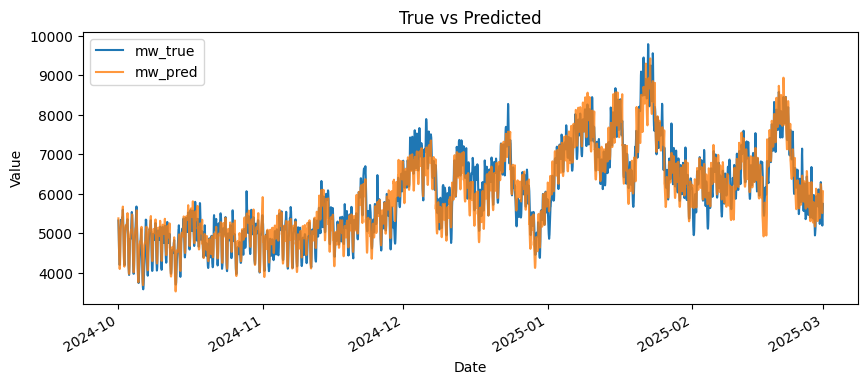

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/AP_hourly_pred_2024.csv")

start_date = "2024-10-01"   # adjust if needed
dates = pd.date_range(start=start_date, periods=len(df), freq="h")

df["date"] = dates

# 3. Plot y_true and y_pred over time
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df["date"], df["y_true"], label="mw_true")
ax.plot(df["date"], df["y_pred"], label="mw_pred", alpha=0.8)

ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.set_title("True vs Predicted")
ax.legend()
fig.autofmt_xdate()  # rotate date labels

plt.show()

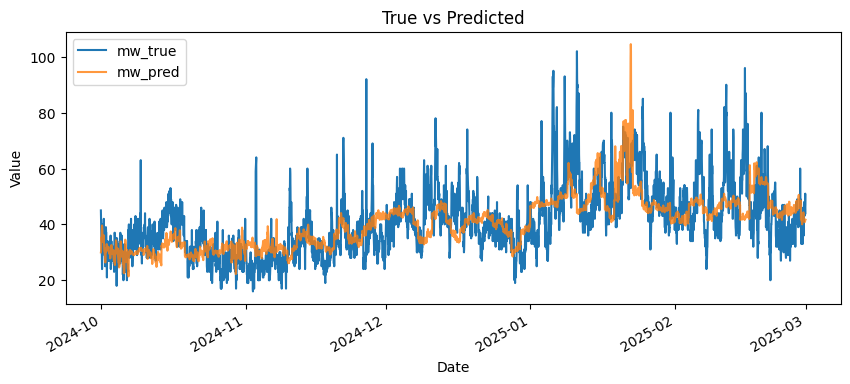

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/OVEC_hourly_pred_2024.csv")

start_date = "2024-10-01"   # adjust if needed
dates = pd.date_range(start=start_date, periods=len(df), freq="h")

df["date"] = dates

# 3. Plot y_true and y_pred over time
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df["date"], df["y_true"], label="mw_true")
ax.plot(df["date"], df["y_pred"], label="mw_pred", alpha=0.8)

ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.set_title("True vs Predicted")
ax.legend()
fig.autofmt_xdate()  # rotate date labels

plt.show()

# Max Hour Prediction

This prediction is fine. It's not great and utilizing a true model instead of a rolling average could help, however fundamentally this prediciton relies on the regression model which as noted could be improved.


In [16]:
import pandas as pd

df = pd.read_csv("results/hourly_max_pred_2024.csv")
df = df[["load_area", "acc"]]

df = df.sort_values("acc", ascending=False).reset_index(drop=True)
display(df)

,load_area,acc
0,AE,68.874172
1,JC,68.211921
2,RECO,67.549669
3,PS,63.576159
4,AEPAPT,56.953642
5,EASTON,52.317881
6,SMECO,52.317881
7,CE,51.655629
8,DOM,50.993377
9,AEPKPT,50.331126


# Peak Day Prediction

This model seems to perform surprsingly better in terms of accuracy than the rolling average, partially due to the fact that there was some modeling involved. Again this is contingent upon the hourly prediction from the regression model, and would likely be improved with a better modeling appraoch.

In [20]:
import pandas as pd

df = pd.read_csv("results/max_day_results_2024.csv")
df = df[["load_area", "accuracy_pct", "peak_accuracy_pct"]].rename(
    columns={
        "accuracy_pct": "acc",
        "peak_accuracy_pct": "peak_ac"
    }
)

df = df.sort_values("acc", ascending=False).reset_index(drop=True)
display(df)

,load_area,acc,peak_ac
0,ME,74.154930,57.042254
1,RECO,73.169014,65.140845
2,DOM,70.633803,60.211268
3,JC,69.647887,63.380282
4,PLCO,69.084507,56.690141
5,PS,68.661972,80.281690
6,EKPC,67.112676,54.929577
7,OE,66.408451,71.478873
8,AEPKPT,66.408451,57.394366
9,EASTON,66.338028,61.619718
